### Analysis of game and reward + prediction


#### Import


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import HTML, display

import re
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split as tts 
from tensorflow.keras.losses import mse, mean_absolute_error
from tensorflow.keras.optimizers import RMSprop, Adadelta

import sys
sys.path.append("../")

from generate_rounds_with_policies import policy_competition

/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
def build_formula(target, cols, interactions=[], intercept = -1):
    
    f = target + " ~ "
    f += " + ".join(map(lambda x: "C(" + x +")" , cols))
    
    if len(interactions) > 0:
        f += " + "
        interaction_list = ["C(" + interaction[0] +")" + "*" + "C(" +interaction[1] +")"
                            for interaction in interactions]
        f += " + ".join(interaction_list)
    if intercept == -1:
        f += " - 1 "
    return f


def compute_pseudo_r_squared(mod):
    return 1 - mod.deviance/mod.null_deviance


def catch_card(xx):
    try:
        card = re.split(r'\)',re.split(r'\(',xx)[1])[0].split('_')
    except:
        card = ["intercept", "intercept", "intercept"]
        
    return card

In [3]:
def get_results(model, color = 'rgb(158, 202, 225)'):
    
    results = model.conf_int()
    results.columns = ["coef_inf","coef_sup"]
    results["coef "]= model.params
    results["p_value"] = model.pvalues
    results["color"] = color
    results["card"] = results.index.map(catch_card)
    results[["is_atout", "value", "player"]] = results["card"].apply(pd.Series)
    
    results["is_atout"] = results["is_atout"]=="atout"
    del results["card"]
    return results

def get_style_for_results(results):
    """
    get style to highlight the significant values of a model's results 
    
    Args :
        df (dataframe) : model'results
            
    Returns : (df) : return a df with the styles to apply
    """
    c1 = 'background-color: #80E37C'
    c2 = '' 
    
    #condition to be green
    mask = results['p_value'] < 0.05
    
    #DataFrame with same index and columns names as original filled red color
    df1 =  pd.DataFrame(c2, index=results.index, columns=results.columns)
    
    #modify values of df1 column by boolean mask
    df1.loc[mask, ["coef_inf","coef_sup"]] = c1
    return df1


def get_results_formated(model, caption = "", color= "rgb(158,202,225)"):
    """
    highlights the significant values of a model's results 
    
    Args :
        model (model) : fitted model
        caption (str) : text describing the results (optional)
            
    Returns : (df with style) : return a stylized df
    """
    results = get_results(model, color = color)
    
    return results.style.apply(get_style_for_results, axis=None)\
           .set_caption(caption)

### Load data

In [4]:
NUM_EPISODES = 100000
policy_algo = ["Random",
               "Random",
               "Random",
               "Random"]

contrat_model_path = None


data, attack = policy_competition(policies=policy_algo, 
                                                env_name = "coinche-v3",
                                                contrat_model_path=contrat_model_path, 
                                                NUM_EPISODES=NUM_EPISODES)

data.to_csv("./data/random_data.csv")
attack.to_csv("./data/attack_random_data.csv")

Contrat model passed:  None
Contrat model passed:  None
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80

In [10]:
data = pd.read_csv("./data/random_data.csv", index_col=0)



In [11]:
data.head()

,atout_7_p1,atout_8_p1,atout_9_p1,atout_10_p1,atout_jack_p1,atout_queen_p1,atout_king_p1,atout_as_p1,na1_7_p1,na1_8_p1,...,na2_as_p4,na3_7_p4,na3_8_p4,na3_9_p4,na3_10_p4,na3_jack_p4,na3_queen_p4,na3_king_p4,na3_as_p4,total_reward
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,58.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,35.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,45.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,119.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


**Let's check that the data is centered in 81, and in the intervale [0, 162]**

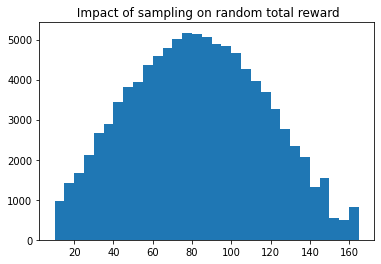

count    100000.000000
mean         81.058680
std          35.193938
min           0.000000
25%          55.000000
50%          81.000000
75%         107.000000
max         162.000000
Name: total_reward, dtype: float64

In [12]:
plt.hist(data["total_reward"], bins=np.arange(10, 170, 5))
plt.title(" Impact of sampling on random total reward")
plt.show()

data["total_reward"].describe()

# Linear modelisation

First we take the first game into account

In [13]:
formula = build_formula("total_reward", cols = np.concatenate([data.columns[:32]]).tolist())
formula

'total_reward ~ C(atout_7_p1) + C(atout_8_p1) + C(atout_9_p1) + C(atout_10_p1) + C(atout_jack_p1) + C(atout_queen_p1) + C(atout_king_p1) + C(atout_as_p1) + C(na1_7_p1) + C(na1_8_p1) + C(na1_9_p1) + C(na1_10_p1) + C(na1_jack_p1) + C(na1_queen_p1) + C(na1_king_p1) + C(na1_as_p1) + C(na2_7_p1) + C(na2_8_p1) + C(na2_9_p1) + C(na2_10_p1) + C(na2_jack_p1) + C(na2_queen_p1) + C(na2_king_p1) + C(na2_as_p1) + C(na3_7_p1) + C(na3_8_p1) + C(na3_9_p1) + C(na3_10_p1) + C(na3_jack_p1) + C(na3_queen_p1) + C(na3_king_p1) + C(na3_as_p1) - 1 '

## Create linear model and get first results

In [14]:
mod = smf.glm(formula=formula, data=data, family=sm.families.Gaussian()).fit()
print("pseudo_R2: ", compute_pseudo_r_squared(mod))

pseudo_R2:  0.14737506785248344


R2 is pretty low (around 15%)...

In [15]:
formated_results = get_results_formated(mod)

As game and playing are random and as non atout suits are playing a symetrical role, we can average the coef value directly

In [16]:
average_coef = formated_results.data.groupby(["is_atout", "value"]).agg({"p_value": "max",
                                                                         "coef_inf":"mean",
                                                                         "coef_sup":"mean"})

In [17]:
(average_coef.style
            .apply(get_style_for_results, axis=None)
            .set_caption(""))

## One game + interactions on important variables

In [18]:
interactions = [
    ["atout_jack_p1", "atout_9_p1"],
    ["na1_as_p1", "na1_10_p1"],
    ["na2_as_p1", "na2_10_p1"],
    ["na3_as_p1", "na3_10_p1"]
]

In [19]:
formula = build_formula("total_reward", cols = np.concatenate([data.columns[:32]]).tolist(), interactions=interactions)
formula

'total_reward ~ C(atout_7_p1) + C(atout_8_p1) + C(atout_9_p1) + C(atout_10_p1) + C(atout_jack_p1) + C(atout_queen_p1) + C(atout_king_p1) + C(atout_as_p1) + C(na1_7_p1) + C(na1_8_p1) + C(na1_9_p1) + C(na1_10_p1) + C(na1_jack_p1) + C(na1_queen_p1) + C(na1_king_p1) + C(na1_as_p1) + C(na2_7_p1) + C(na2_8_p1) + C(na2_9_p1) + C(na2_10_p1) + C(na2_jack_p1) + C(na2_queen_p1) + C(na2_king_p1) + C(na2_as_p1) + C(na3_7_p1) + C(na3_8_p1) + C(na3_9_p1) + C(na3_10_p1) + C(na3_jack_p1) + C(na3_queen_p1) + C(na3_king_p1) + C(na3_as_p1) + C(atout_jack_p1)*C(atout_9_p1) + C(na1_as_p1)*C(na1_10_p1) + C(na2_as_p1)*C(na2_10_p1) + C(na3_as_p1)*C(na3_10_p1) - 1 '

In [20]:
mod = smf.glm(formula=formula, data=data, family=sm.families.Gaussian()).fit()
print("pseudo_R2: ", compute_pseudo_r_squared(mod))

pseudo_R2:  0.1488270071658836


In [21]:
formated_results = get_results_formated(mod)
formated_results

,coef_inf,coef_sup,coef,p_value,color,is_atout,value,player
C(atout_7_p1)[0.0],14.337547,14.750898,14.544223,0.000000,"rgb(158,202,225)",True,7,p1
C(atout_7_p1)[1.0],20.320671,20.883672,20.602171,0.000000,"rgb(158,202,225)",True,7,p1
C(atout_8_p1)[T.1.0],6.499575,7.403189,6.951382,0.000000,"rgb(158,202,225)",True,8,p1
C(atout_9_p1)[T.1.0],15.371603,16.410286,15.890945,0.000000,"rgb(158,202,225)",True,9,p1
C(atout_10_p1)[T.1.0],11.412125,12.316110,11.864118,0.000000,"rgb(158,202,225)",True,10,p1
C(atout_jack_p1)[T.1.0],29.039725,30.082822,29.561274,0.000000,"rgb(158,202,225)",True,jack,p1
C(atout_queen_p1)[T.1.0],7.773819,8.678622,8.226220,0.000000,"rgb(158,202,225)",True,queen,p1
C(atout_king_p1)[T.1.0],8.843221,9.746761,9.294991,0.000000,"rgb(158,202,225)",True,king,p1
C(atout_as_p1)[T.1.0],14.451863,15.355509,14.903686,0.000000,"rgb(158,202,225)",True,as,p1
C(na1_7_p1)[T.1.0],4.137622,5.040328,4.588975,0.000000,"rgb(158,202,225)",False,7,p1


# Linear modelisation

Now, let's cheat and take the two games of the first team

In [22]:
# Let's retrieve index of cards of players p0 and p2
p1_p3 = [x for x in range(0, 32) ]+ [x for x in range(64, 64 + 32)]

In [23]:
formula = build_formula("total_reward", cols = np.concatenate([data.columns[p1_p3]]).tolist())
formula

'total_reward ~ C(atout_7_p1) + C(atout_8_p1) + C(atout_9_p1) + C(atout_10_p1) + C(atout_jack_p1) + C(atout_queen_p1) + C(atout_king_p1) + C(atout_as_p1) + C(na1_7_p1) + C(na1_8_p1) + C(na1_9_p1) + C(na1_10_p1) + C(na1_jack_p1) + C(na1_queen_p1) + C(na1_king_p1) + C(na1_as_p1) + C(na2_7_p1) + C(na2_8_p1) + C(na2_9_p1) + C(na2_10_p1) + C(na2_jack_p1) + C(na2_queen_p1) + C(na2_king_p1) + C(na2_as_p1) + C(na3_7_p1) + C(na3_8_p1) + C(na3_9_p1) + C(na3_10_p1) + C(na3_jack_p1) + C(na3_queen_p1) + C(na3_king_p1) + C(na3_as_p1) + C(atout_7_p3) + C(atout_8_p3) + C(atout_9_p3) + C(atout_10_p3) + C(atout_jack_p3) + C(atout_queen_p3) + C(atout_king_p3) + C(atout_as_p3) + C(na1_7_p3) + C(na1_8_p3) + C(na1_9_p3) + C(na1_10_p3) + C(na1_jack_p3) + C(na1_queen_p3) + C(na1_king_p3) + C(na1_as_p3) + C(na2_7_p3) + C(na2_8_p3) + C(na2_9_p3) + C(na2_10_p3) + C(na2_jack_p3) + C(na2_queen_p3) + C(na2_king_p3) + C(na2_as_p3) + C(na3_7_p3) + C(na3_8_p3) + C(na3_9_p3) + C(na3_10_p3) + C(na3_jack_p3) + C(na3_quee

## Create linear model and get first results

In [24]:
mod = smf.glm(formula=formula, data=data, family=sm.families.Gaussian()).fit()
print("pseudo_R2: ", compute_pseudo_r_squared(mod))

pseudo_R2:  0.5210098223914328


In [25]:
formated_results = get_results_formated(mod)

As game and playing are random and as non atout suits are playing a symetrical role, we can average the coef value directly

In [26]:
average_coef = formated_results.data.groupby(["is_atout", "value"]).agg({"p_value": "max",
                                                                         "coef_inf":"mean",
                                                                         "coef_sup":"mean"})

In [27]:
(average_coef.style
            .apply(get_style_for_results, axis=None)
            .set_caption(""))

### First neural network model with convolutions taking two players games

In [75]:
# Creatgin class_weigth dict to penalize extreme values
# thresholds = [30, 50, 80, 100, 110]
class_weights = {}
for i in range(163):
    i = float(i)
    if (i <= 40) | (i > 120):
        class_weights[i] = 2.2
    elif (i <= 60) | (i > 100):
        class_weights[i] = 1.8
    elif (i > 90) | (i <70):
        class_weights[i] = 1.3
    else:
        class_weights[i] = 1

In [76]:
def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv1D(filters=16, kernel_size=4, activation='relu', input_shape=(64, 1)))
    model.add(layers.AveragePooling1D(pool_size = 4, strides=4))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=8, kernel_size=4, activation='relu'))
    model.add(layers.AveragePooling1D(pool_size = 4))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=4, kernel_size=2, activation='relu'))
    model.add(layers.AveragePooling1D(pool_size = 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    return model

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(64,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    return model

loss = mse

model = build_cnn_model()
model.compile(optimizer="adam", loss=loss)

model_class_weight = build_cnn_model()
model_class_weight.compile(optimizer="adam", loss=loss)

relu_class_weigth_model = build_model()
relu_class_weigth_model.compile(optimizer="adam", loss=loss)

relu_model = build_model()
relu_model.compile(optimizer="adam", loss=loss)

In [77]:
xtrain, xtest, ytrain, ytest = tts(data[data.columns[p1_p3]].values, data.total_reward, test_size=0.2, random_state=4)
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

In [ ]:
epochs = 50

model.fit(x = xtrain, y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest, ytest))

model_class_weight.fit(x = xtrain, y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest, ytest), class_weight=class_weights)

relu_model.fit(x = xtrain.reshape(80000, 64), y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest.reshape(20000, 64), ytest))

relu_class_weigth_model.fit(x = xtrain.reshape(80000, 64), y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest.reshape(20000, 64), ytest), class_weight=class_weights)

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 7s 85us/sample - loss: 2389.0965 - val_loss: 1178.1303
Epoch 2/50
80000/80000 [==============================] - 5s 58us/sample - loss: 997.4283 - val_loss: 1364.3473
Epoch 3/50
80000/80000 [==============================] - 5s 57us/sample - loss: 841.5007 - val_loss: 1034.7950
Epoch 4/50
80000/80000 [==============================] - 5s 61us/sample - loss: 731.3949 - val_loss: 1769.8632
Epoch 5/50
80000/80000 [==============================] - 5s 56us/sample - loss: 695.6938 - val_loss: 1273.0231
Epoch 6/50
80000/80000 [==============================] - 5s 57us/sample - loss: 694.1495 - val_loss: 1107.9516
Epoch 7/50
80000/80000 [==============================] - 5s 59us/sample - loss: 671.8163 - val_loss: 739.3807
Epoch 8/50
80000/80000 [==============================] - 5s 60us/sample - loss: 665.2023 - val_loss: 2316.4845
Epoch 9/50
80000/80000 [==============================

In [ ]:
x1 = sorted(np.absolute(ytest-model_class_weight.predict(xtest).reshape(ytest.shape)))
x2 = sorted(np.absolute(ytest-model.predict(xtest).reshape(ytest.shape)))
x3 = sorted(np.absolute(ytest-relu_class_weigth_model.predict(xtest.reshape(20000, 64)).reshape(ytest.shape)))
x4 = sorted(np.absolute(ytest-relu_model.predict(xtest.reshape(20000, 64)).reshape(ytest.shape)))

plt.figure(figsize = (15, 15))
plt.subplot(2,2,1)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(model.predict(xtest), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title("model without class wheighting - bins")
plt.legend()

plt.subplot(2,2,2)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(relu_model.predict(xtest.reshape(20000, 64)), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title(" relu model without class wheighting - bins")
plt.legend()

plt.subplot(2,2,3)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(model_class_weight.predict(xtest), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title("model with class wheighting - bins")
plt.legend()

plt.subplot(2,2,4)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(relu_class_weigth_model.predict(xtest.reshape(20000, 64)), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title(" relu model with class wheighting - bins")
plt.legend()
plt.show()

In [ ]:
kwargs = dict(histtype='step', bins=np.arange(0, 80, 10))

plt.figure(figsize=(10,10))
plt.hist(x1, label = "cnn cw", **kwargs)
plt.hist(x2,label = "cnn", **kwargs)
plt.hist(x3,label = "relu cw", **kwargs)
plt.hist(x4,label = "relu", **kwargs)
plt.legend()
plt.show()

Best Model seems to be the Relu model with class waighting applied